In [6]:
# for auto suggestions
!pip install jupyterlab-lsp
# loading excel files required openpyxl lib
!pip install openpyxl
!pip install seaborn
!pip install imbalanced-learn
!pip install shap
!pip install Flask

In [19]:
# imporing libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, average_precision_score, precision_recall_curve, auc
import joblib
import flask

In [20]:

def load_and_merge_datasets(excel_filename="DataScientist_CaseStudy_Dataset.xlsx"):
    # Get current working directory and build full path to the file
    current_path = os.getcwd()+"\\data"
    filepath = os.path.join(current_path, excel_filename)
    print("Current folder:", filepath)

    # Load the Excel file
    xls = pd.ExcelFile(filepath)

    # Parse sheets
    soc_dem_df = xls.parse("Soc_Dem")
    products_bal_df = xls.parse("Products_ActBalance")
    inflow_outflow_df = xls.parse("Inflow_Outflow")
    sales_revenues_df = xls.parse("Sales_Revenues")

    # Print basic info
    print(f"soc_dem_df counts: {soc_dem_df['Client'].count()}")
    print(f"products_bal_df counts: {products_bal_df['Client'].count()}")
    print(f"inflow_outflow_df counts: {inflow_outflow_df['Client'].count()}")
    print(f"sales_revenues_df counts: {sales_revenues_df['Client'].count()}")

    # Merge all datasets on 'Client'
    source_df = soc_dem_df.merge(products_bal_df, on='Client', how='left') \
                          .merge(inflow_outflow_df, on='Client', how='left') \
                          .merge(sales_revenues_df, on='Client', how='left')

    print(f"{len(source_df)} rows in the source data frame")

    return source_df

In [21]:
source_df = load_and_merge_datasets()

Current folder: D:\llm-engineering-projects\llm_engineering\singlife-assesment\data\DataScientist_CaseStudy_Dataset.xlsx
soc_dem_df counts: 1615
products_bal_df counts: 1615
inflow_outflow_df counts: 1587
sales_revenues_df counts: 969
1615 rows in the source data frame


In [10]:
def prepare_target_dataset(source_df, target_column, test_size=0.3, random_state=42):
    """
    Prepares a dataset for training a model on the specified target column.
    Drops unrelated target columns, handles missing target rows, splits into
    X/y, and then performs train/test split.

    Parameters:
    - source_df (pd.DataFrame): The full merged dataset
    - target_column (str): One of 'Sale_MF', 'Sale_CC', or 'Sale_CL'
    - test_size (float): Fraction of data to use for test/validation
    - random_state (int): Random seed for reproducibility

    Returns:
    - X_train, X_temp, y_train, y_temp (tuple): Train and temp feature/target splits
    """

    valid_targets = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_CL', 'Revenue_CC', 'Revenue_MF']
    if target_column not in valid_targets:
        raise ValueError(f"Invalid target_column '{target_column}'. Must be one of {valid_targets}")

    # Drop other two target columns
    columns_to_drop = [col for col in valid_targets if col != target_column]
    target_df = source_df.drop(columns=columns_to_drop)

    # Drop rows where the selected target is missing
    target_df = target_df.dropna(subset=[target_column])

    # Split into features and target
    y = target_df[target_column]
    X = target_df.drop(columns=[target_column])

    # Perform train/temp split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print(f" X_train lenght is : {len(X_train)}")
    print(f" X_test lenght is : {len(X_test)}")
    print(f" y_train lenght is : {len(y_train)}")
    print(f" y_test lenght is : {len(y_test)}")

    return X_train, X_test, y_train, y_test

In [11]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)
X_train, X_test, y_train, y_test = prepare_target_dataset(source_df, target_column='Sale_MF')
X_train.head()

 X_train lenght is : 678
 X_test lenght is : 291
 y_train lenght is : 678
 y_test lenght is : 291


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
1176,1091,F,42,174,1,1.0,26.0,NaN,NaN,NaN,7.107143,0.008929,0.0,NaN,NaN,NaN,6273.769286,6271.618571,5.0,4.0,2366.928571,2366.928571,2142.857143,0.000000,222.535714,7.0,7.0,2.0,0.0,2.0
157,1036,F,68,19,1,1.0,NaN,NaN,NaN,NaN,819.351786,32160.165714,NaN,NaN,NaN,NaN,483.448571,478.064643,4.0,2.0,1.964286,1.964286,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0
853,837,M,56,176,1,NaN,NaN,NaN,NaN,NaN,686.439643,NaN,NaN,NaN,NaN,NaN,107.716786,107.716786,2.0,2.0,80.928571,80.928571,0.000000,0.000000,78.750000,2.0,2.0,0.0,0.0,1.0
1529,1418,M,64,83,1,NaN,NaN,NaN,NaN,NaN,1463.998929,NaN,NaN,NaN,NaN,NaN,2013.586429,2013.586429,2.0,2.0,1044.767500,1044.767500,178.571429,475.625357,388.392143,23.0,23.0,2.0,16.0,4.0
170,1195,M,68,200,1,NaN,NaN,1.0,NaN,NaN,120.151786,NaN,NaN,0.0,NaN,NaN,1227.041786,1227.041786,2.0,2.0,1094.673929,1094.673929,357.142857,330.852500,401.571429,30.0,30.0,1.0,16.0,11.0


In [12]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Client,678.0,814.020649,460.213767,1.000000,434.000000,809.500000,1211.250000,1615.000000
Age,678.0,43.169617,18.567275,0.000000,29.000000,42.000000,57.000000,90.000000
Tenure,678.0,100.148968,66.833884,0.000000,39.000000,95.000000,151.000000,271.000000
Count_CA,678.0,1.081121,0.344911,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,181.0,1.187845,0.469120,1.000000,1.000000,1.000000,1.000000,3.000000
Count_MF,130.0,5.369231,10.385693,1.000000,1.000000,2.000000,5.000000,79.000000
Count_OVD,175.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CC,85.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CL,57.0,1.105263,0.309620,1.000000,1.000000,1.000000,1.000000,2.000000
ActBal_CA,678.0,2461.110038,6512.171494,0.000000,70.588214,461.978929,2198.489464,74934.956071


<Axes: >

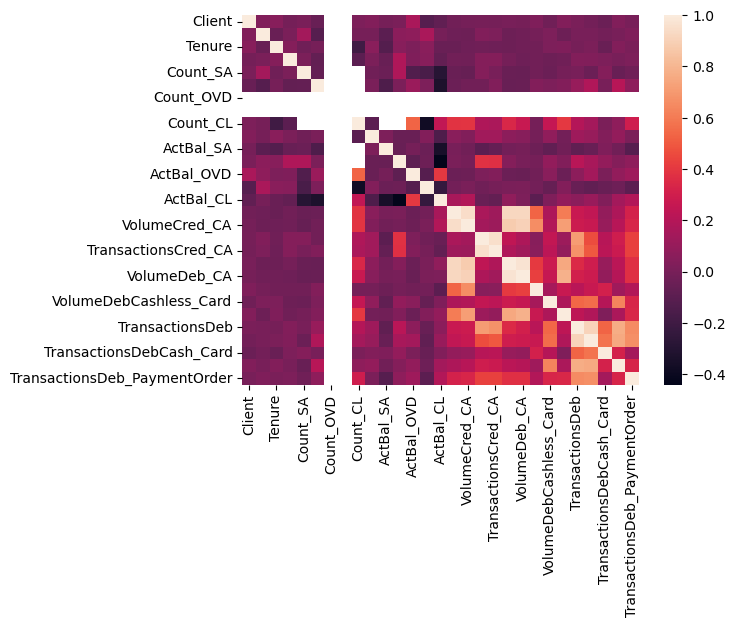

In [13]:
sns.heatmap(X_train.select_dtypes(exclude='object').corr())

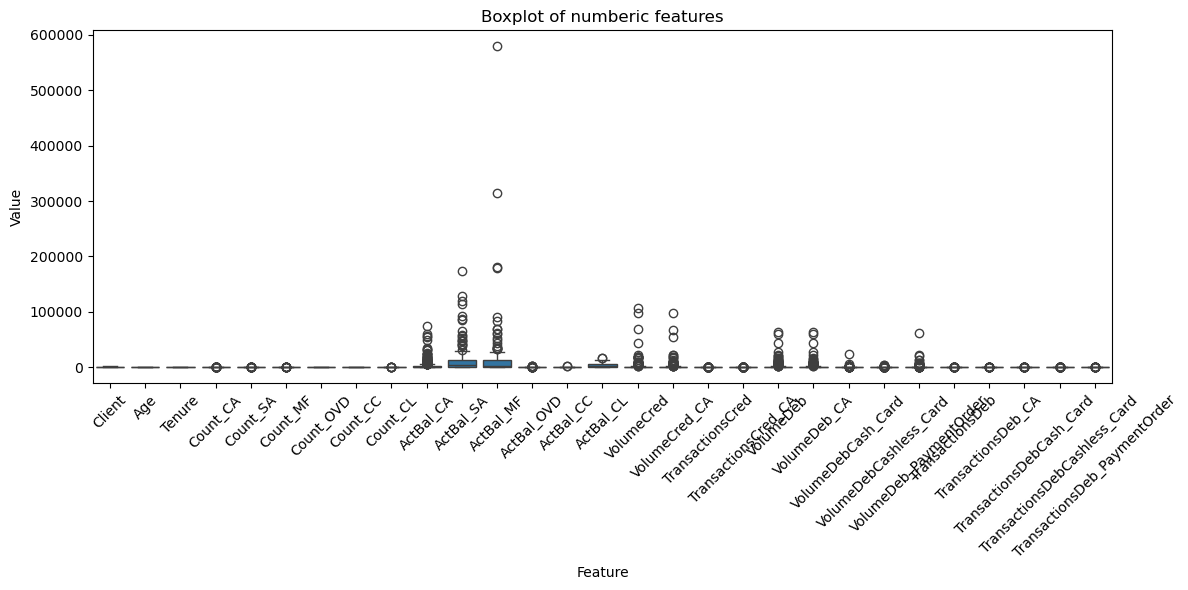

In [14]:
# numeric colummns for boxplot
df_numeric = X_train.select_dtypes(exclude='object')

# melt into long form for sea born
df_melted = df_numeric.melt(var_name='Feature', value_name='Value')\

plt.figure(figsize=(12,6))
sns.boxplot(data=df_melted, x='Feature', y='Value')
plt.xticks(rotation=45)
plt.title('Boxplot of numberic features')
plt.tight_layout()
plt.show()

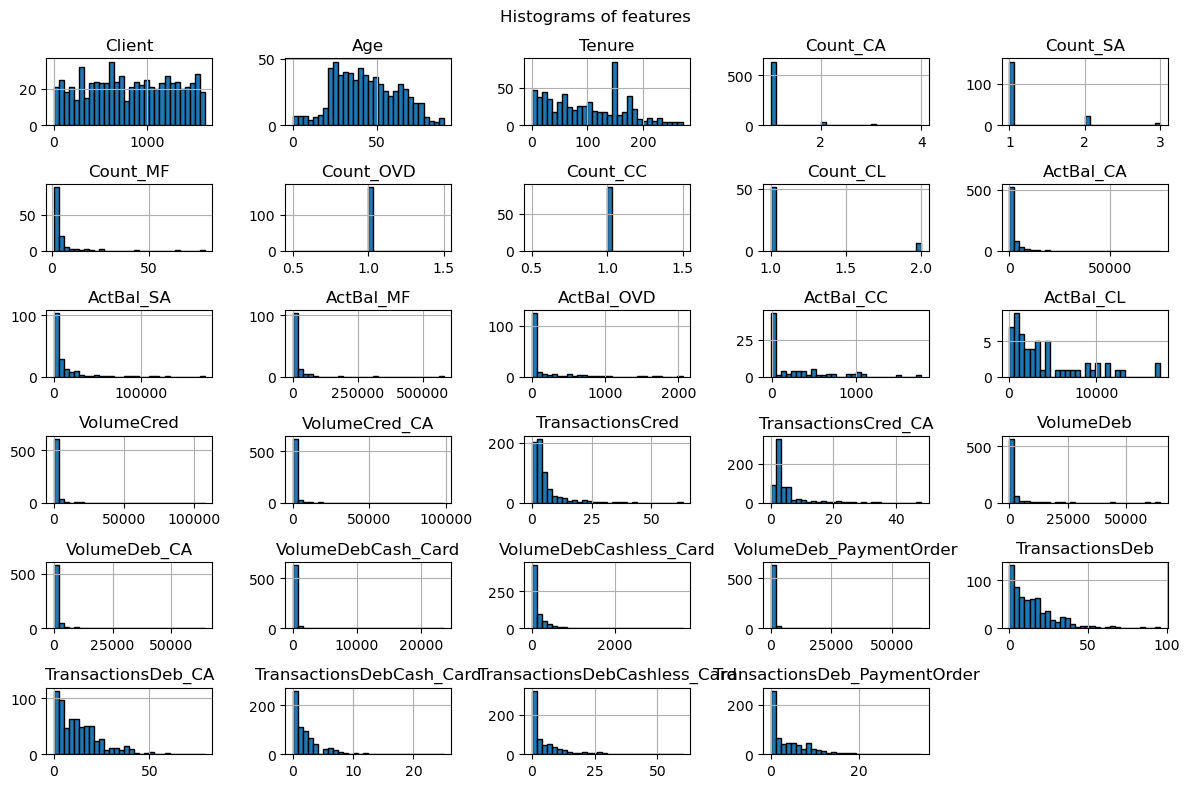

In [149]:
# histogram of Numeric featureTs
X_train.hist(bins=30, figsize=(12,8), edgecolor='black')
plt.suptitle('Histograms of features')
plt.tight_layout()
plt.show()

In [151]:
corr_matrix = X_train.select_dtypes(exclude='object').corr()

import numpy as np

# Get upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Filter features with correlation > 0.7 or < -0.7
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_filtered = high_corr_pairs[high_corr_pairs['Correlation'].abs() > 0.7]

print(high_corr_filtered)

               Feature1                      Feature2  Correlation
256          VolumeCred                 VolumeCred_CA     0.947810
259          VolumeCred                     VolumeDeb     0.921636
260          VolumeCred                  VolumeDeb_CA     0.925266
271       VolumeCred_CA                     VolumeDeb     0.878406
272       VolumeCred_CA                  VolumeDeb_CA     0.902749
275       VolumeCred_CA        VolumeDeb_PaymentOrder     0.718129
281    TransactionsCred           TransactionsCred_CA     0.951368
287    TransactionsCred               TransactionsDeb     0.708414
302           VolumeDeb                  VolumeDeb_CA     0.968465
305           VolumeDeb        VolumeDeb_PaymentOrder     0.751081
313        VolumeDeb_CA        VolumeDeb_PaymentOrder     0.785267
337     TransactionsDeb            TransactionsDeb_CA     0.906122
339     TransactionsDeb  TransactionsDebCashless_Card     0.768075
342  TransactionsDeb_CA  TransactionsDebCashless_Card     0.75

In [15]:
def preprocess_dataset(X, X_train):
    """
    Cleans, encodes, and preprocesses the input dataset X using X_train
    as reference for imputation.

    Parameters:
    - X (pd.DataFrame): Input dataset to clean (e.g., X_test)
    - X_train (pd.DataFrame): Reference dataset for imputation (e.g., training set)

    Returns:
    - pd.DataFrame: Cleaned and preprocessed dataset
    """

    X = X.copy()

    # 1. Remove 'Client' column
    if 'Client' in X.columns:
        X = X.drop(columns=['Client'], axis=1)

    # 2. Tenure: convert months to years
    if 'Tenure' in X.columns:
        X['Tenure'] = X['Tenure'] / 12

    # 3. Drop multicollinearity features if they exist
    high_corr_to_drop = [
        'VolumeCred_CA', 'VolumeDeb_CA', 'VolumeDeb_PaymentOrder',
        'TransactionsCred_CA', 'TransactionsDeb_CA', 'TransactionsDebCashless_Card',
        'ActBal_CL', 'VolumeDeb'
    ]
    cols_to_drop = [col for col in high_corr_to_drop if col in X.columns]
    X = X.drop(columns=cols_to_drop)

    # 4. Encode 'Sex' column (fill NaNs with mode, get_dummies)
    if 'Sex' in X.columns:
        mode_value = X['Sex'].mode()[0]
        X['Sex'] = X['Sex'].fillna(mode_value)

        sex_encoded = pd.get_dummies(X['Sex'], drop_first=True).astype(int)
        X = pd.concat([X.drop(columns=['Sex']), sex_encoded], axis=1)

    # 5. Impute missing values based on 80% rule
    for col in X.columns:
        if X[col].isnull().sum() > 0 and X[col].dtype != 'object':
            null_count = X[col].isnull().sum()
            total_count = len(X)
            null_percentage = (null_count / total_count) * 100

            if null_percentage > 80:
                X[col] = X[col].fillna(0)
            else:
                if col in X_train.columns:
                    X[col] = X[col].fillna(X_train[col].median())
                else:
                    X[col] = X[col].fillna(X[col].median())  # fallback if not in train

    # 6. Create missing value flags for selected features
    # for flag_col in ['ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC']:
    #     if flag_col in X.columns:
    #         X[f'{flag_col}_missing'] = X[flag_col].isnull().astype(int)

    return X

In [16]:
X_train = preprocess_dataset(X_train, X_train)

In [17]:
X_train['Count_OVD'].value_counts()

Count_OVD
1.0    678
Name: count, dtype: int64

<Axes: >

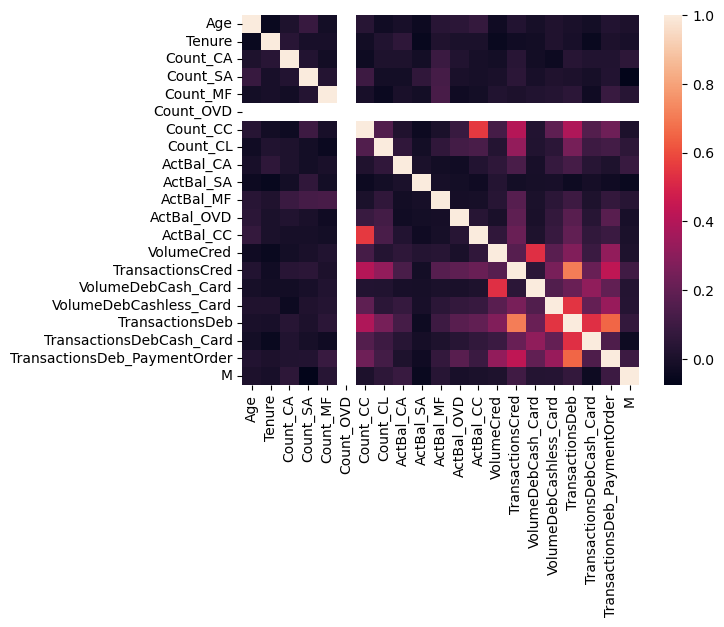

In [18]:
sns.heatmap(X_train.corr())

In [22]:
def apply_smote(X_train, y_train, random_state=42):
    """
    Applies SMOTE oversampling to balance the training dataset.

    Parameters:
    - X_train (pd.DataFrame or np.array): Training features
    - y_train (pd.Series or np.array): Training labels
    - random_state (int): Seed for reproducibility

    Returns:
    - X_resampled: Resampled features
    - y_resampled: Resampled labels
    """
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [23]:
X_resampled, y_resampled = apply_smote(X_train, y_train)

In [15]:
y_resampled.value_counts()

Sale_MF
1.0    543
0.0    543
Name: count, dtype: int64

In [24]:
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None, random_state=42, n_jobs=-1):
    """
    Trains a Random Forest Classifier on the provided training data.

    Parameters:
    - X_train (pd.DataFrame or np.array): Training features
    - y_train (pd.Series or np.array): Training labels
    - n_estimators (int): Number of trees in the forest (default: 100)
    - max_depth (int or None): Maximum depth of each tree (default: None = grow until all leaves are pure)
    - random_state (int): Seed for reproducibility
    - n_jobs (int): Number of CPU cores to use (-1 means use all cores)

    Returns:
    - rf: Trained RandomForestClassifier model
    """
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=n_jobs,
    )
    rf.fit(X_train, y_train)
    print(f" ******  training done **** ")
    return rf

In [17]:
model = train_random_forest(X_resampled, y_resampled )

In [18]:
X_test_preprocessed = preprocess_dataset(X_test, X_train)

In [19]:
len(y_test)

291

In [20]:
y_pred = model.predict(X_test_preprocessed)

In [21]:
y_predprob = model.predict_proba(X_test_preprocessed)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7216494845360825
Confusion Matrix:
 [[201  32]
 [ 49   9]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       233
         1.0       0.22      0.16      0.18        58

    accuracy                           0.72       291
   macro avg       0.51      0.51      0.51       291
weighted avg       0.69      0.72      0.70       291



In [23]:
y_scores = model.predict_proba(X_test_preprocessed)[:,1]
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

In [24]:
pr_auc = average_precision_score(y_test, y_scores)
print(f"PR-AUC Score: {pr_auc:.4f}")

PR-AUC Score: 0.2058


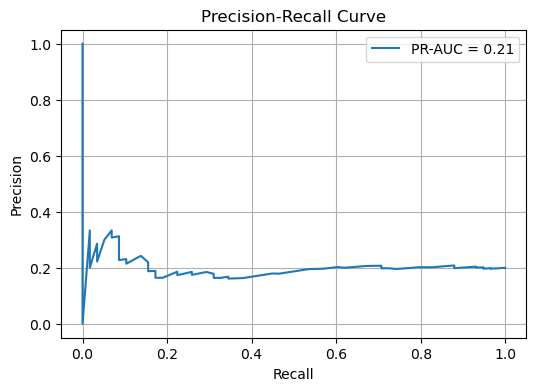

In [25]:
# Plotting
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

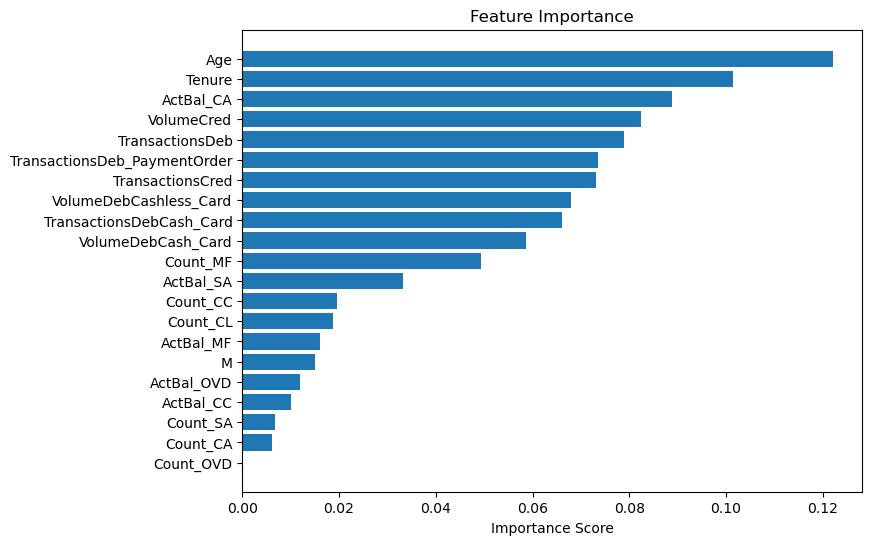

In [26]:
# Get feature importance
importances = model.feature_importances_
features = X_train.columns

# Create DataFrame
feat_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()

In [47]:
ranking_cl_df

,Client,Prob_Purchase_CC
1327,552,0.24
1339,969,0.07
307,1213,0.33
805,1519,0.29
494,65,0.12
...,...,...
1571,1214,0.15
239,684,0.20
471,911,0.87
604,149,0.16


In [25]:
def run_target_pipeline(target_column, prob_column_name, model_label='model', random_state=42):
    """
    Executes full ML pipeline for a given target column.
    
    Parameters:
    - target_column: str, one of 'Sale_MF', 'Sale_CC', 'Sale_CL'
    - prob_column_name: str, name of the output probability column (e.g., 'Prob_Purchase_MF')
    - model_label: optional name of the model variable returned
    - random_state: int, random seed
    
    Returns:
    - ranking_df: DataFrame with 'Client' and prediction probabilities
    - trained_model: fitted RandomForestClassifier model
    """

    # Load and prepare data
    source_df = load_and_merge_datasets()
    X_train, X_test, y_train, y_test = prepare_target_dataset(source_df, target_column=target_column)

    # Store Client IDs for final output
    ranking_df = pd.DataFrame({'Client': X_test['Client']})

    # Preprocess datasets
    X_train_processed = preprocess_dataset(X_train, X_train)
    X_test_processed = preprocess_dataset(X_test, X_train)

    # Handle imbalance
    X_resampled, y_resampled = apply_smote(X_train_processed, y_train, random_state=random_state)

    # Train model
    model = train_random_forest(X_resampled, y_resampled)

    # Predict probabilities
    y_scores = model.predict_proba(X_test_processed)[:, 1]

    # Assign to result
    ranking_df[prob_column_name] = y_scores

    return ranking_df, model

In [62]:
# For Mutual Fund
ranking_mf_df, model_mf = run_target_pipeline('Sale_MF', 'Prob_Purchase_MF')
ranking_mf_df = ranking_mf_df.sort_values(by='Prob_Purchase_MF', ascending=False)
# select top N clients
top_15_percent_mf = int(0.15*len(ranking_mf_df))

Current folder: D:\llm-engineering-projects\llm_engineering\singlife-assesment\DataScientist_CaseStudy_Dataset.xlsx
soc_dem_df counts: 1615
products_bal_df counts: 1615
inflow_outflow_df counts: 1587
sales_revenues_df counts: 969
1615 rows in the source data frame
 X_train lenght is : 678
 X_test lenght is : 291
 y_train lenght is : 678
 y_test lenght is : 291
 ******  training done **** 


In [26]:
# For Credit Card
ranking_cc_df, model_cc = run_target_pipeline('Sale_CC', 'Prob_Purchase_CC')
ranking_cc_df = ranking_cc_df.sort_values(by='Prob_Purchase_CC', ascending=False)
# select top N clients
top_15_percent_cc = int(0.15*len(ranking_cc_df))

Current folder: D:\llm-engineering-projects\llm_engineering\singlife-assesment\data\DataScientist_CaseStudy_Dataset.xlsx
soc_dem_df counts: 1615
products_bal_df counts: 1615
inflow_outflow_df counts: 1587
sales_revenues_df counts: 969
1615 rows in the source data frame
 X_train lenght is : 678
 X_test lenght is : 291
 y_train lenght is : 678
 y_test lenght is : 291
 ******  training done **** 


In [57]:
# For Consumer Loan
ranking_cl_df, model_cl = run_target_pipeline('Sale_CL', 'Prob_Purchase_CL')
ranking_cl_df = ranking_cl_df.sort_values(by='Prob_Purchase_CL', ascending=False)
# select top N clients
top_15_percent_cl = int(0.15*len(ranking_cl_df))


Current folder: D:\llm-engineering-projects\llm_engineering\singlife-assesment\DataScientist_CaseStudy_Dataset.xlsx
soc_dem_df counts: 1615
products_bal_df counts: 1615
inflow_outflow_df counts: 1587
sales_revenues_df counts: 969
1615 rows in the source data frame
 X_train lenght is : 678
 X_test lenght is : 291
 y_train lenght is : 678
 y_test lenght is : 291
 ******  training done **** 
43


In [63]:
ranking_mf_df

,Client,Prob_Purchase_MF
531,1261,0.87
783,1564,0.76
493,1565,0.76
191,436,0.68
1476,1382,0.68
...,...,...
1301,374,0.05
1309,628,0.05
444,720,0.03
579,952,0.03


In [64]:
ranking_cc_df

,Client,Prob_Purchase_CC
1276,529,0.82
617,385,0.82
748,942,0.77
1504,822,0.75
1580,963,0.75
...,...,...
771,360,0.11
464,995,0.10
402,1020,0.10
839,1061,0.09


In [65]:
ranking_cl_df

,Client,Prob_Purchase_CL
798,438,0.83
18,316,0.81
1148,1524,0.79
36,682,0.77
8,1231,0.77
...,...,...
382,1141,0.10
1111,1046,0.10
641,1577,0.09
935,1483,0.07


In [27]:
# saving model packaging
current_path = os.getcwd()+"\\models"
joblib.dump(X_train.columns.to_list, os.path.join(current_path, 'model_features.pkl'))

['D:\\llm-engineering-projects\\llm_engineering\\singlife-assesment\\models\\model_features.pkl']

In [28]:
!pip install flask
from flask import Flask, request, jsonify

In [ ]:
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json  # Expecting JSON list of feature arrays
    instances = np.array(data.get("instances"))  # List of feature lists

    model = joblib.load("model_mf.pkl")
    preds = model.predict_proba(instances)[:, 1].tolist()
    return jsonify({"predictions": preds})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=8080)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://192.168.1.67:8080
Press CTRL+C to quit
